In [2]:
import warnings
warnings.filterwarnings('ignore')
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
# import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split

- Creating Cheakcpoints

In [3]:
def create_model_checkpoint(experiment_name, dir_name="checkpoints",
                            save_freq='epoch', monitor = "val_accuracy"):

  checkpoint_dir = dir_name + "/" + experiment_name
  checkpoint_callback = ModelCheckpoint(
    checkpoint_dir, monitor=monitor, verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq=save_freq,
  )
  print(f"Saving model checkpoint to: {checkpoint_dir}")
  return checkpoint_callback

# Load data and split into training and test sets

In [4]:
train_df = pd.read_csv('/kaggle/input/pre-processed-data/train_preprocessed.csv')
test_df = pd.read_csv('/kaggle/input/pre-processed-data/test_preprocessed.csv')

# train_df = pd.read_csv("data/train_preprocessed.csv")
# test_df = pd.read_csv("data/test_preprocessed.csv")

In [5]:
train_df.head()

,keyword,location,text,target
0,neutral,us,Our Deeds Reason earthquake May ALLAH Forgive us,1
1,fire,canada,Forest fire near La Ronge Sask Canada,1
2,evacuation,nowhere,All residents asked shelter place notified off...,1
3,evacuation,california,people receive wildfires evacuation orders Cal...,1
4,smoke,nowhere,Just got sent photo Ruby Alaska smoke wildfire...,1


- Now we will tokenize the text data and convert the text to sequences.

In [6]:
# find the text in train_df with the least number of words
avg_words = train_df['text'].apply(lambda x: len(x.split(' '))).mean()
print(f"Average number of words in a text: {avg_words}")

Average number of words in a text: 9.99185603572836


In [7]:
# Split train and test set

X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['target'], axis=1), train_df['target'], test_size=0.2, random_state=42)

# reshape y_train and y_test
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# convert to tensor
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [8]:
X_train.head()

,keyword,location,text
4996,military,texas,Courageous honest analysis need use Atomic Bom...
3263,engulfed,nowhere,wld b shame golf cart became engulfed flames b...
4907,massacre,cottonwood arizona,Tell rescind medals honor given US soldiers Ma...
2855,drought,"spokane, wa",Worried CA drought might affect Extreme Weathe...
4716,lava,"medan,indonesia",Lava Blast amp Power Red PantherAttack


# Learning the Embedding

In [9]:
text_tokenizer = tf.keras.layers.TextVectorization(max_tokens=5000, output_mode='int', output_sequence_length=8)

- This have converted text into numbers. 

- `max_tokens` is the number of words in the vocabulary.  (not necessarily these many words will be used) 
- `output_mode` is the type of output we want. Here we want to use the `one-hot` in the model so we will use `int`, which will give us the index of the word in the vocabulary.
- `output_sequence_length` is the length of the output sequence. It is the maximum length of the sentence in the data. We will pad the sentences which are shorter than this length and truncate the sentences which are longer than this length.
- `ngrams` is the number of words we want to consider when we tokenize the text. For example, if we have a sentence "I love deep learning", and `ngrams=2`, then the tokens will be `["I", "love", "deep", "learning", "I love", "love deep", "deep learning"]`. This will help us to capture the context of the words.

In [10]:
text_tokenizer.adapt(train_df["text"])

In [11]:
text_tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'i', 'the', 'a', 'like', 'amp', 'e', 's', 'fire']

In [12]:
# length of vocabulary
len(text_tokenizer.get_vocabulary())

5000

In [13]:
text_tokenizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None, None),
 'max_tokens': 5000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 8,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 5000}

In [14]:
text_tokenizer("I love deep learning").numpy()

array([   2,   71, 1095, 1699,    0,    0,    0,    0])

In [15]:
test_df["text"][2:3]

2    forest fire spot pond geese fleeing across str...
Name: text, dtype: object

In [16]:
text_tokenizer(test_df["text"][2:3])

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[ 133,    9,  705, 2888,    1,    1,  799,  655]])>

In [17]:
train_df

,keyword,location,text,target
0,neutral,us,Our Deeds Reason earthquake May ALLAH Forgive us,1
1,fire,canada,Forest fire near La Ronge Sask Canada,1
2,evacuation,nowhere,All residents asked shelter place notified off...,1
3,evacuation,california,people receive wildfires evacuation orders Cal...,1
4,smoke,nowhere,Just got sent photo Ruby Alaska smoke wildfire...,1
...,...,...,...,...
7608,collapse,nowhere,Two giant cranes holding bridge collapse nearb...,1
7609,neutral,california,The control wild fires California even Norther...,1
7610,neutral,nowhere,M UTC km S Volcano Hawaii,1
7611,collided,nowhere,Police investigating ebike collided car Little...,1


In [18]:
# Embed a 10,000 word vocabulary into 128 dimensions
text_embedding = tf.keras.layers.Embedding(5000, 64)

In [19]:
text_embedding(text_tokenizer(X_train["text"][:5])).shape

TensorShape([5, 8, 64])

In [20]:
def conv_block(inputs, num_filters, kernel_size):
    x = tf.keras.layers.Conv1D(num_filters, kernel_size, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(num_filters, kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')(x)

    return outputs

In [21]:
text = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')

tokenized_ = text_tokenizer(text)

embedding = text_embedding(tokenized_)

x = conv_block(embedding, 64, 5)

x = conv_block(x, 128, 5)

x = conv_block(x, 256, 3)

x = tf.keras.layers.GlobalAveragePooling1D()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)

x = tf.keras.layers.Dropout(0.7)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=text, outputs=outputs)

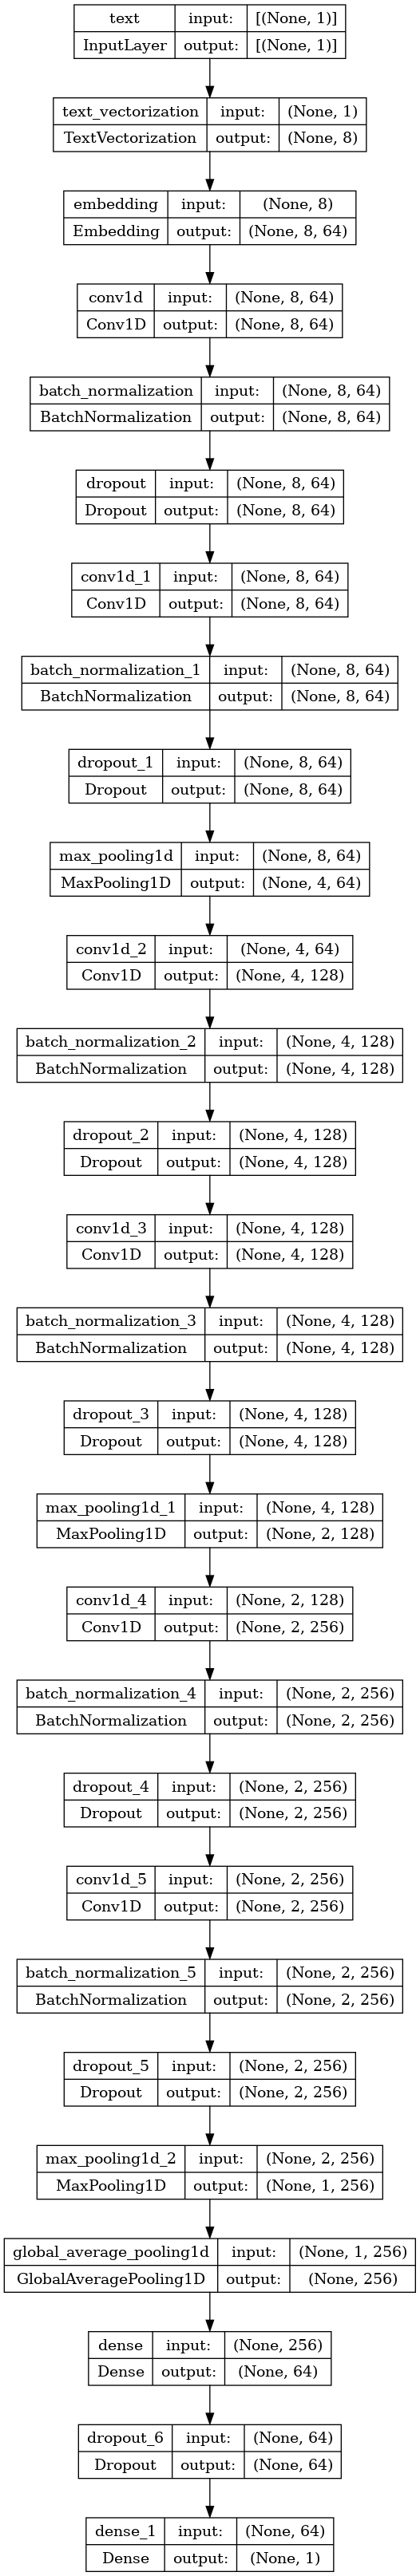

In [22]:

# Visualize model
tf.keras.utils.plot_model(model, show_shapes=True)


In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=["accuracy"])

In [24]:
# Train model
history = model.fit(x=X_train["text"], y=y_train, epochs=10, validation_data=(X_test["text"], y_test), callbacks=[create_model_checkpoint("learn_embeddings")])


Saving model checkpoint to: checkpoints/learn_embeddings
Epoch 1/10
191/191 [==============================] - ETA: 0s - loss: 1.0887 - accuracy: 0.5013
Epoch 1: val_accuracy improved from -inf to 0.57387, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 31s 95ms/step - loss: 1.0887 - accuracy: 0.5013 - val_loss: 0.6831 - val_accuracy: 0.5739
Epoch 2/10
191/191 [==============================] - ETA: 0s - loss: 0.9157 - accuracy: 0.5388
Epoch 2: val_accuracy did not improve from 0.57387
191/191 [==============================] - 4s 20ms/step - loss: 0.9157 - accuracy: 0.5388 - val_loss: 0.6890 - val_accuracy: 0.5588
Epoch 3/10
191/191 [==============================] - ETA: 0s - loss: 0.8635 - accuracy: 0.5281
Epoch 3: val_accuracy did not improve from 0.57387
191/191 [==============================] - 4s 20ms/step - loss: 0.8635 - accuracy: 0.5281 - val_loss: 0.6879 - val_accuracy: 0.5627
Epoch 4/10
190/191 [============================>.] - ETA:

- Let's try to train the model for more epoch

In [25]:
# Train model
history = model.fit(x=X_train["text"], y=y_train, epochs=10, validation_data=(X_test["text"], y_test), callbacks=[create_model_checkpoint("learn_embeddings")])


Saving model checkpoint to: checkpoints/learn_embeddings
Epoch 1/10
191/191 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.6036
Epoch 1: val_accuracy improved from -inf to 0.63756, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 9s 47ms/step - loss: 0.6691 - accuracy: 0.6036 - val_loss: 0.6421 - val_accuracy: 0.6376
Epoch 2/10
191/191 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.6020
Epoch 2: val_accuracy improved from 0.63756 to 0.64741, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 8s 40ms/step - loss: 0.6708 - accuracy: 0.6020 - val_loss: 0.6328 - val_accuracy: 0.6474
Epoch 3/10
191/191 [==============================] - ETA: 0s - loss: 0.6479 - accuracy: 0.6475
Epoch 3: val_accuracy improved from 0.64741 to 0.66251, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 9s 46ms/step - loss: 0.6479 - accuracy: 0.6475 -

- It is clearly overfitting, Let's try the Pre-Trained Embedding

# Pre-trained Embedings

## USE

- Load the Pre-trained Glove Embedding

In [26]:
import tensorflow_hub as hub
# We can use this encoding layer in place of our text_vectorizer and embedding layer
encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="Universal_Sentence_Encoder") 

In [30]:
def block(inputs, kernel, kernel_size=5):

    x = tf.keras.layers.Conv1D(kernel, 5)(inputs)
    x = tf.keras.layers.Conv1D(kernel, 5)(x)
    x = tf.keras.layers.MaxPool1D()(x)
    x = tf.keras.layers.Dropout(0.6)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    return x

In [31]:
text = tf.keras.layers.Input(shape=[], dtype=tf.string, name="text")

encoded_text = encoder_layer(text)

x = tf.keras.layers.Reshape(target_shape=(64, 8), input_shape=(512,))(encoded_text)

x = block(x, 64)

x = block(x, 128)

x = block(x, 256, 3)

# x = block(x, 128, 3)


output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs=[text], outputs=output)

# Compile model
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=["accuracy"])

In [32]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None,)]                 0         
                                                                 
 Universal_Sentence_Encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 reshape_1 (Reshape)         (None, 64, 8)             0         
                                                                 
 conv1d_12 (Conv1D)          (None, 60, 64)            2624      
                                                                 
 conv1d_13 (Conv1D)          (None, 56, 64)            20544     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 28, 64)           0         
 1D)                                                       

In [33]:
# Train model
history_2 = model_2.fit(x=X_train["text"], y=y_train, epochs=10, validation_data=(X_test["text"], y_test), callbacks=[create_model_checkpoint("learn_embeddings")])


Saving model checkpoint to: checkpoints/learn_embeddings
Epoch 1/10
191/191 [==============================] - ETA: 0s - loss: 0.7990 - accuracy: 0.5722
Epoch 1: val_accuracy improved from -inf to 0.57387, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 25s 84ms/step - loss: 0.7990 - accuracy: 0.5722 - val_loss: 0.7248 - val_accuracy: 0.5739
Epoch 2/10
190/191 [============================>.] - ETA: 0s - loss: 0.6914 - accuracy: 0.6521
Epoch 2: val_accuracy did not improve from 0.57387
191/191 [==============================] - 4s 22ms/step - loss: 0.6917 - accuracy: 0.6521 - val_loss: 0.7318 - val_accuracy: 0.5739
Epoch 3/10
189/191 [============================>.] - ETA: 0s - loss: 0.6433 - accuracy: 0.6905
Epoch 3: val_accuracy improved from 0.57387 to 0.71766, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 16s 83ms/step - loss: 0.6437 - accuracy: 0.6903 - val_loss: 0.5552 - val_accuracy: 0.7177
Epoch 4

- Training for more epochs

In [34]:
# Train model
history_3 = model_2.fit(x=X_train["text"], y=y_train, epochs=45, initial_epoch=10, validation_data=(X_test["text"], y_test), callbacks=[create_model_checkpoint("learn_embeddings")])


Saving model checkpoint to: checkpoints/learn_embeddings
Epoch 11/45
190/191 [============================>.] - ETA: 0s - loss: 0.5239 - accuracy: 0.7623
Epoch 11: val_accuracy improved from -inf to 0.80827, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 18s 94ms/step - loss: 0.5234 - accuracy: 0.7627 - val_loss: 0.4465 - val_accuracy: 0.8083
Epoch 12/45
189/191 [============================>.] - ETA: 0s - loss: 0.5290 - accuracy: 0.7569
Epoch 12: val_accuracy improved from 0.80827 to 0.81024, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 17s 89ms/step - loss: 0.5286 - accuracy: 0.7573 - val_loss: 0.4460 - val_accuracy: 0.8102
Epoch 13/45
190/191 [============================>.] - ETA: 0s - loss: 0.5199 - accuracy: 0.7640
Epoch 13: val_accuracy did not improve from 0.81024
191/191 [==============================] - 4s 22ms/step - loss: 0.5210 - accuracy: 0.7637 - val_loss: 0.4466 - val_accuracy: 0.8063
E

- Let's train for few more epochs

In [36]:
# Train model
history_4 = model_2.fit(x=X_train["text"], y=y_train, epochs=, initial_epoch=45, validation_data=(X_test["text"], y_test), callbacks=[create_model_checkpoint("learn_embeddings")])


Saving model checkpoint to: checkpoints/learn_embeddings
Epoch 46/60
190/191 [============================>.] - ETA: 0s - loss: 0.4037 - accuracy: 0.8248
Epoch 46: val_accuracy improved from -inf to 0.82141, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 15s 81ms/step - loss: 0.4045 - accuracy: 0.8243 - val_loss: 0.4247 - val_accuracy: 0.8214
Epoch 47/60
189/191 [============================>.] - ETA: 0s - loss: 0.4055 - accuracy: 0.8271
Epoch 47: val_accuracy improved from 0.82141 to 0.82337, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 16s 84ms/step - loss: 0.4056 - accuracy: 0.8273 - val_loss: 0.4206 - val_accuracy: 0.8234
Epoch 48/60
190/191 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8257
Epoch 48: val_accuracy did not improve from 0.82337
191/191 [==============================] - 4s 22ms/step - loss: 0.4041 - accuracy: 0.8258 - val_loss: 0.4211 - val_accuracy: 0.8221
E

In [41]:
ls /kaggle/working/checkpoints/learn_embeddings/

assets/  fingerprint.pb  keras_metadata.pb  saved_model.pb  variables/


In [44]:
from tensorflow.keras.models import load_model

best_model = load_model('/kaggle/working/checkpoints/learn_embeddings/')


In [45]:
best_model.evaluate(X_train["text"], y_train)

191/191 [==============================] - 3s 13ms/step - loss: 0.3287 - accuracy: 0.8596


[0.3287292420864105, 0.8596059083938599]

In [46]:
best_model.evaluate(X_test["text"], y_test)

48/48 [==============================] - 1s 13ms/step - loss: 0.4206 - accuracy: 0.8234


[0.42059701681137085, 0.8233749270439148]

## glove

- Download the embedding file from [here](https://nlp.stanford.edu/projects/glove/)

In [53]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-05-31 12:36:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-31 12:36:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-31 12:36:01--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [54]:
path_to_glove_file = "/kaggle/working/glove.6B.100d.txt"

GLOVE_EMBEDDINGS = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        GLOVE_EMBEDDINGS[word] = coefs

print("Found %s word vectors." % len(GLOVE_EMBEDDINGS))

Found 400000 word vectors.


In [98]:
EMBEDDING_DIM = 100
MAXLEN = 16
VOCAB_SIZE = 14502

In [99]:
text_tokenizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=MAXLEN)

In [100]:
text_tokenizer.adapt(train_df["text"])

In [101]:
vocab = text_tokenizer.get_vocabulary()

In [102]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for i, word in enumerate(vocab):
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [103]:
model_3 = tf.keras.Sequential([ 
        tf.keras.Input(shape=(1,), dtype=tf.string, name='text'),
        text_tokenizer,
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=MAXLEN, weights=[EMBEDDINGS_MATRIX], trainable=False), 
#         tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#         tf.keras.layers.Conv1D(32, 5, activation='relu'),
#         tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [104]:
model_3.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

In [105]:
model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 16)               0         
 ectorization)                                                   
                                                                 
 embedding_9 (Embedding)     (None, 16, 100)           1450300   
                                                                 
 dropout_27 (Dropout)        (None, 16, 100)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                

In [108]:
# Train model
history_3 = model_3.fit(x=X_train["text"], y=y_train, epochs=20, initial_epoch=10, validation_data=(X_test["text"], y_test), callbacks=[create_model_checkpoint("learn_embeddings")])


Saving model checkpoint to: checkpoints/learn_embeddings
Epoch 11/20
187/191 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8727
Epoch 11: val_accuracy improved from -inf to 0.80499, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 15s 81ms/step - loss: 0.2963 - accuracy: 0.8734 - val_loss: 0.4765 - val_accuracy: 0.8050
Epoch 12/20
190/191 [============================>.] - ETA: 0s - loss: 0.2845 - accuracy: 0.8783
Epoch 12: val_accuracy improved from 0.80499 to 0.80696, saving model to checkpoints/learn_embeddings
191/191 [==============================] - 16s 82ms/step - loss: 0.2845 - accuracy: 0.8783 - val_loss: 0.4767 - val_accuracy: 0.8070
Epoch 13/20
188/191 [============================>.] - ETA: 0s - loss: 0.2631 - accuracy: 0.8908
Epoch 13: val_accuracy did not improve from 0.80696
191/191 [==============================] - 2s 10ms/step - loss: 0.2621 - accuracy: 0.8911 - val_loss: 0.5245 - val_accuracy: 0.7938
E

In [107]:
from tensorflow.keras.models import load_model

best_model = load_model('/kaggle/working/checkpoints/learn_embeddings/')

train_acc = best_model.evaluate(X_train["text"], y_train)

test_acc = best_model.evaluate(X_test["text"], y_test)

train_acc, test_acc

48/48 [==============================] - 0s 5ms/step - loss: 0.4251 - accuracy: 0.8188


([0.40057572722435, 0.8249589204788208],
 [0.4250982701778412, 0.8187787532806396])

## Submit

In [109]:
# Predict on test set

y_pred = best_model.predict(test_df["text"])

102/102 [==============================] - 1s 4ms/step


In [110]:

y_pred.shape

(3263, 1)

In [111]:
ids = pd.read_csv('/kaggle/input/test-id/test_id.csv')['id']

# merge ids and predictions
submission = pd.DataFrame(np.concatenate((ids.values.reshape(-1, 1), y_pred.reshape(-1,1)), axis=1), columns=['id', 'target'])

# make id int   
submission['id'] = submission['id'].astype('int')

# make target 0 and 1
submission['target'] = submission['target'].apply(lambda x: 0 if x < 0.5 else 1)

In [112]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,0


In [113]:
# Save submission
submission.to_csv('submission.csv', index=False)

In [52]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Submission using Pre-trained Embedding of Glove"

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
